**PREDICTING SEVERITY OF HEART DISEASE BASED ON KNOWN INDICATORS OF THE BODY**

**Introduction:**

According to the Heart&Stroke foundation, heart disease can be defined as any condition that affects the structure and functions of the heart. There are different levels of severity for heart disease ranging from 0 (good condition) to 4 (highly serious) in our data. Some common factors that contribute to heart diseases are high blood pressure, a high level of cholesterol, heart rhythm disorder, etc., and we will be using some of those exact variables from the processed heart disease dataset collected in Cleveland for our project, in addition to some extra quantitative variables included. Our goal is to try and predict the severity of heart disease given a new observation of these variables using our trained model from data analysis.

**Preliminary exploratory data analysis:**

In [ ]:
install.packages("tidyverse")
library(tidyverse)
options(repr.matrix.max.rows = 6)
heart_data <- read_csv(url("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"))
colnames(heart_data) <- c("age", "sex", "chestpain_type", "restbps", "chol", "fastingbs", "restecg", "max_heart_rate", "exang",
                           "oldpeak", "slope", "ca", "thal", "diagnosis")
names(heart_data) <- make.unique(names(heart_data))
heart_data <- mutate(heart_data, diagnosis = as_factor(diagnosis))

head(heart_data)

First we subset our dataframe into columns / variables we want to use, then remove all rows with missing values. The reasoning for the all predictor variables chosen will be explained in the "methods" section.

In [47]:
heart_data <- select(heart_data, age, restbps, chol, max_heart_rate, diagnosis)
nrow(heart_data)
heart_data <- na.omit(heart_data)
nrow(heart_data)

[1] 302

[1] 302

Luckily, we don't have any missing values in our dataset! Now we split into training/test sets:

In [53]:
set.seed(123)
heart_split <- initial_split(heart_data, prop = 0.75, strata = diagnosis)
heart_train <- training(heart_split)
heart_test <- testing(heart_split) 

The table below shows all factors of our diagnosis response and the number of observations and percentage in each class for the **training data**

| Class of response | No. of obs | Percentage of obs.
| ----------- | ----------- | -------------|
| 0           | 123         | 54.185
| 1           | 43          | 18.943
| 2           | 26          | 11.454
| 3           | 26          | 11.454
| 4           | 9           | 4.965


The boxplots below shows the distribution of all our predictor variables:

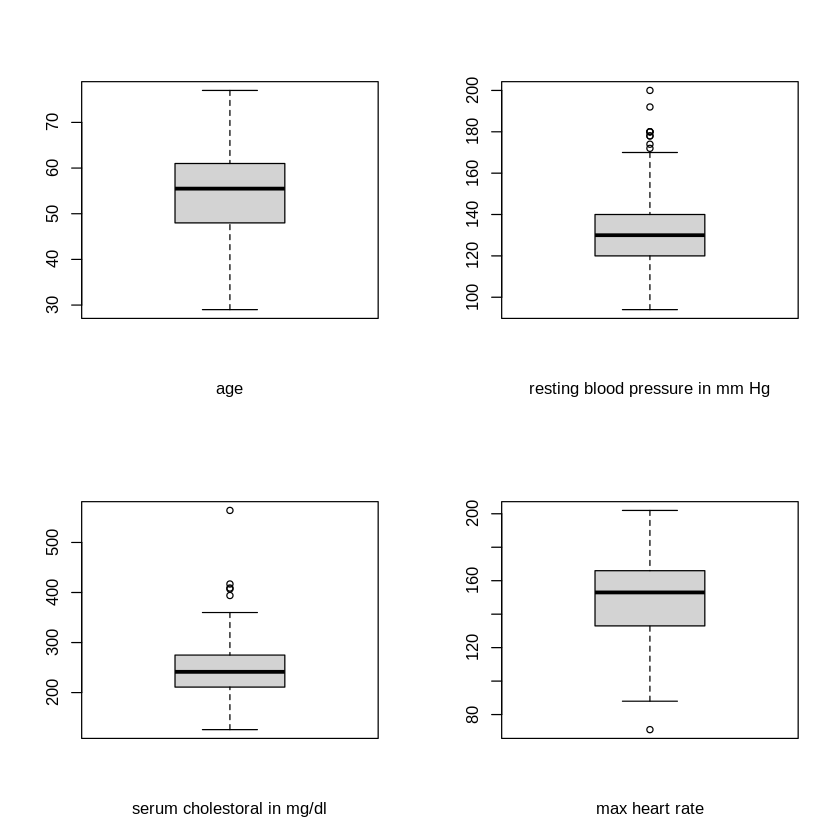

In [72]:
par(mfrow=c(2,2))
boxplot(heart_data$age, xlab = "age")
boxplot(heart_data$restbps, xlab = "resting blood pressure in mm Hg")
boxplot(heart_data$chol, xlab = "serum cholestoral in mg/dl")
boxplot(heart_data$max_heart_rate, xlab = "max heart rate")

**METHODS:**

Our team plans on creating a classification model in order to predict the severity of heart disease found in patients based upon several other medical observations. We were lucky in that our dataset had a plethora of data to choose from. However, we limited our predictors/columns to the four listed below. This was intentional, as we omitted predictor variables that were themselves qualitative to increase simplicity of interpretation and calculation, while fasting blood pressure would require the patient to be in a fasted state which would take a while to record the data. We figured that all the variables chosen had a decent correlation with age, which is our main reason for choosing them.

The visualization of our results will be a bar chart with each colour representing a different class of the response, and we will plot the number of observations collected on a bar graph to display its distribution, and compare each class of the response relative to others.

**Expected outcomes and significance:**

Our team's expectations is to predict the severity of heart disease from each observation in our testing set and other patient data based on age, level of blood pressure, amount of cholesterol and maximum heart rate, and build a good model around it. Being able to confirm the presence of heart disease and knowing the severity of it allows a healthcare provider to develop an appropriate treatment plan for each patient. Treatment options can range from lifestyle changes to heavy medication regimens, and it is important for the provider to know what is appropriate for each patient. Being able to develop a model that uses such data will allow providers to have a better idea of each specific case even before other, more intrusive tests can be completed, and may allow the patient to skip such testing altogether. Such a model can also allow electronic medical record systems to automatically flag patients in the system and recommend them for follow-up testing, reducing cases where patients are lost to follow up. This model can lead to future questions where researchers can work to find which specific factors play a bigger role in the development of heart disease, and thus guide public health recommendations and treatment plans for patients. It can also allow for other diseases or disorders to be modelled and predicted using a similar method to ours.